Code from OpenAI Cookbook
https://cookbook.openai.com/examples/chat_finetuning_data_prep

In [1]:
import json
import os
import tiktoken # for token counting
import numpy as np
from collections import defaultdict
import openai
import pandas as pd
import matplotlib.pyplot as plt

Validate Data Format

In [18]:
# load jsonl file
data_path = "data/finetuning_data/small_training_data.jsonl"

# Load the dataset
with open(data_path, 'r', encoding='utf-8') as f:
    dataset = [json.loads(line) for line in f]

# Initial dataset stats
print("Num examples:", len(dataset))
print("First example:")
for message in dataset[0]["messages"]:
    print(message)

Num examples: 10
First example:
{'role': 'system', 'content': 'Imagine you are a member of the European\n         Parliament and based on your years of experience, you are an expert in \n         predicting how the different party groups will vote on a given law. Given\n         the above legislative proposal, predict the percentage of votes in favour \n         from each party group in the European Parliament. Assess the political \n         direction, wording, framing, and topic relevance of the law to inform your \n         predictions. Determine the type of majority (General, Left, Right, Consensus) \n         likely to support the legislation based on party alignments.'}
{'role': 'user', 'content': 'Amendment of the MFF 2014-2020: PURPOSE: to amend Regulation (EU, Euratom) No 1311/2013 laying down the multiannual financial framework for the years 2014-2020. PROPOSED ACT: Council Regulation. ROLE OF THE EUROPEAN PARLIAMENT: Council may adopt the act only if Parliament has given its

In [19]:
# Format error checks
format_errors = defaultdict(int)

for ex in dataset:
    if not isinstance(ex, dict):
        format_errors["data_type"] += 1
        continue
        
    messages = ex.get("messages", None)
    if not messages:
        format_errors["missing_messages_list"] += 1
        continue
        
    for message in messages:
        if "role" not in message or "content" not in message:
            format_errors["message_missing_key"] += 1
        
        if any(k not in ("role", "content", "name", "function_call", "weight") for k in message):
            format_errors["message_unrecognized_key"] += 1
        
        if message.get("role", None) not in ("system", "user", "assistant", "function"):
            format_errors["unrecognized_role"] += 1
            
        content = message.get("content", None)
        function_call = message.get("function_call", None)
        
        if (not content and not function_call) or not isinstance(content, str):
            format_errors["missing_content"] += 1
    
    if not any(message.get("role", None) == "assistant" for message in messages):
        format_errors["example_missing_assistant_message"] += 1

if format_errors:
    print("Found errors:")
    for k, v in format_errors.items():
        print(f"{k}: {v}")
else:
    print("No errors found")

No errors found


In [20]:
# HELPER FUNCTIONS

# cl100k_base is the tokenizer used by ChatGPT3.5 and ChatGPT4
encoding = tiktoken.get_encoding("cl100k_base")

# not exact!
# simplified from https://github.com/openai/openai-cookbook/blob/main/examples/How_to_count_tokens_with_tiktoken.ipynb
def num_tokens_from_messages(messages, tokens_per_message=3, tokens_per_name=1):
    num_tokens = 0
    for message in messages:
        num_tokens += tokens_per_message
        for key, value in message.items():
            # .encode returns the list of tokens (so that you can count them with len())
            num_tokens += len(encoding.encode(value))
            if key == "name":
                num_tokens += tokens_per_name
    num_tokens += 3
    return num_tokens

def num_assistant_tokens_from_messages(messages):
    num_tokens = 0
    for message in messages:
        if message["role"] == "assistant":
            num_tokens += len(encoding.encode(message["content"]))
    return num_tokens

def print_distribution(values, name):
    print(f"\n#### Distribution of {name}:")
    print(f"min / max: {min(values)}, {max(values)}")
    print(f"mean / median: {np.mean(values)}, {np.median(values)}")
    print(f"p5 / p95: {np.quantile(values, 0.1)}, {np.quantile(values, 0.9)}")

In [21]:
# check for missing data, distribution of messages in each conversation,
# distribution of tokens per conversation, print token limit warnings

# Warnings and tokens counts
n_missing_system = 0
n_missing_user = 0
n_messages = []
convo_lens = []
assistant_message_lens = []

for ex in dataset:
    messages = ex["messages"]
    if not any(message["role"] == "system" for message in messages):
        n_missing_system += 1
    if not any(message["role"] == "user" for message in messages):
        n_missing_user += 1
    n_messages.append(len(messages))
    convo_lens.append(num_tokens_from_messages(messages))
    assistant_message_lens.append(num_assistant_tokens_from_messages(messages))
    
print("Num examples missing system message:", n_missing_system)
print("Num examples missing user message:", n_missing_user)
print_distribution(n_messages, "num_messages_per_example")
#print_distribution(convo_lens, "num_total_tokens_per_example")
print_distribution(assistant_message_lens, "num_assistant_tokens_per_example")
n_too_long = sum(l > 4096 for l in convo_lens)
print(f"\n{n_too_long} examples may be over the 4096 token limit, they will be truncated during fine-tuning")

Num examples missing system message: 0
Num examples missing user message: 0

#### Distribution of num_messages_per_example:
min / max: 3, 3
mean / median: 3.0, 3.0
p5 / p95: 3.0, 3.0

#### Distribution of num_assistant_tokens_per_example:
min / max: 85, 85
mean / median: 85.0, 85.0
p5 / p95: 85.0, 85.0

0 examples may be over the 4096 token limit, they will be truncated during fine-tuning


Estimate costs

In [22]:
# Pricing and default n_epochs estimate
MAX_TOKENS_PER_EXAMPLE = 4096

TARGET_EPOCHS = 3
MIN_TARGET_EXAMPLES = 100
MAX_TARGET_EXAMPLES = 25000
MIN_DEFAULT_EPOCHS = 1
MAX_DEFAULT_EPOCHS = 25

n_epochs = TARGET_EPOCHS
n_train_examples = len(dataset)
if n_train_examples * TARGET_EPOCHS < MIN_TARGET_EXAMPLES:
    n_epochs = min(MAX_DEFAULT_EPOCHS, MIN_TARGET_EXAMPLES // n_train_examples)
elif n_train_examples * TARGET_EPOCHS > MAX_TARGET_EXAMPLES:
    n_epochs = max(MIN_DEFAULT_EPOCHS, MAX_TARGET_EXAMPLES // n_train_examples)

n_billing_tokens_in_dataset = sum(min(MAX_TOKENS_PER_EXAMPLE, length) for length in convo_lens)
print(f"Dataset has ~{n_billing_tokens_in_dataset} tokens that will be charged for during training")
print(f"By default, you'll train for {n_epochs} epochs on this dataset")
print(f"By default, you'll be charged for ~{n_epochs * n_billing_tokens_in_dataset} tokens")

Dataset has ~10626 tokens that will be charged for during training
By default, you'll train for 10 epochs on this dataset
By default, you'll be charged for ~106260 tokens


Upload validated files to OpenAI API

In [26]:
# upload validated data file to OpenAI API
# set OPENAI_API_KEY in environment variables

client = openai.OpenAI(api_key=os.environ['TestKey3'])

train_upload = client.files.create(
  file=open("small_training_data.jsonl", "rb"),
  purpose="fine-tune"
)
print("Uploaded training file id", train_upload.id)

val_upload = client.files.create(
  file=open("small_validation_data.jsonl", "rb"),
  purpose="fine-tune"
)
print("Uploaded validation file id", val_upload.id)

Uploaded training file id file-reEKt34LG2BCnkhO2WtDTifP
Uploaded validation file id file-A6Znpu66UheqOTqqkSaXjuiF


To Do:
- Was sind die verschiedenen Arten von Loss?
- Was sind die Steps? Wie kriege ich den loss runter?
- eine Art finden, loss usw kontrollieren - Website
- einen Algorithmus zum Testen verschiedener Hyperparameter bauen
- Ergbenis verschiedenerHyperparameter visualisieren

Create Fine-Tuning Job via OpenAI Software Development Kit

In [27]:
learning_rate_multiplier = [0.1, 0.01, 0.001, 0.0001, 0.00001]

response = client.fine_tuning.jobs.create(
  training_file=train_upload.id, # file id returned after upload to API 
  validation_file=val_upload.id, # file id returned after upload to API
  model="gpt-3.5-turbo",
  suffix="small",
  seed=124,
  hyperparameters={
  "n_epochs": 3,
	"batch_size": 1,
	"learning_rate_multiplier": 0.01
  }
)
job_id = response.id

print(f'Fine-tunning model with jobID: {job_id}.')
print(f"Training Response: {response}")
print(f"Training Status: {response.status}")

# Retrieve the state of a fine-tune
client.fine_tuning.jobs.retrieve(job_id)

# monitor training progress, get ft events
client.fine_tuning.jobs.list_events(
  fine_tuning_job_id=job_id,
  limit=10
)



Fine-tunning model with jobID: ftjob-yopylfrAJb6XAXOXWCQOMIzO.
Training Response: FineTuningJob(id='ftjob-yopylfrAJb6XAXOXWCQOMIzO', created_at=1721253198, error=Error(code=None, message=None, param=None), fine_tuned_model=None, finished_at=None, hyperparameters=Hyperparameters(n_epochs=3, batch_size=1, learning_rate_multiplier=0.01), model='gpt-3.5-turbo-0125', object='fine_tuning.job', organization_id='org-URxBkHYInUDxHdJfjeVT2W58', result_files=[], seed=124, status='validating_files', trained_tokens=None, training_file='file-reEKt34LG2BCnkhO2WtDTifP', validation_file='file-A6Znpu66UheqOTqqkSaXjuiF', estimated_finish=None, integrations=[], user_provided_suffix='small')
Training Status: validating_files


SyncCursorPage[FineTuningJobEvent](data=[FineTuningJobEvent(id='ftevent-6aMlk30rPhoJ8hexulyuBzz3', created_at=1721253198, level='info', message='Validating training file: file-reEKt34LG2BCnkhO2WtDTifP and validation file: file-A6Znpu66UheqOTqqkSaXjuiF', object='fine_tuning.job.event', data={}, type='message'), FineTuningJobEvent(id='ftevent-swxnxfTGtfSaPoOUFt8qzhau', created_at=1721253198, level='info', message='Created fine-tuning job: ftjob-yopylfrAJb6XAXOXWCQOMIzO', object='fine_tuning.job.event', data={}, type='message')], object='list', has_more=False)

Getting Metrics / Evaluation

In [ ]:
def get_ft_results(file_id):
    """
    Given a file_id of a finished fine-tuning job, a request is made to the OpenAI API
    to retrieve the content of the file. Content is decoded from Base64 and saved to a 
    csv file, which can be later loaded as a pandas DataFrame.
    """
    headers = {'Authorization': f'Bearer {os.environ['TestKey3']}'}
    try:
        response = requests.get(f"https://api.openai.com/v1/files/{file_id}/content", headers=headers)
        response.raise_for_status()  # Raises HTTPError for bad responses (4xx and 5xx)
        if response.content:
            try:
                # Decode the Base64 encoded content
                decoded_content = base64.b64decode(response.content).decode('utf-8')
                with open("decoded_content.csv", "w") as f:
                    f.write(decoded_content)
            except (ValueError, base64.binascii.Error):
                # Handle the case where the response is not valid Base64 or cannot be decoded
                print("Response content could not be decoded from Base64")
                print(response.content)
        else:
            print("Response content is empty")
    except requests.exceptions.HTTPError as http_err:
        print(f"HTTP error occurred: {http_err}")
    except requests.exceptions.RequestException as err:
        print(f"Error occurred: {err}")
    return "decoded_content.csv"

,step,train_loss,train_accuracy,valid_loss,valid_mean_token_accuracy
0,1,2.72811,0.65517,NaN,NaN
1,2,2.48728,0.63218,NaN,NaN
2,3,2.38815,0.63218,NaN,NaN
3,4,2.39879,0.64368,NaN,NaN
4,5,2.38417,0.64368,NaN,NaN


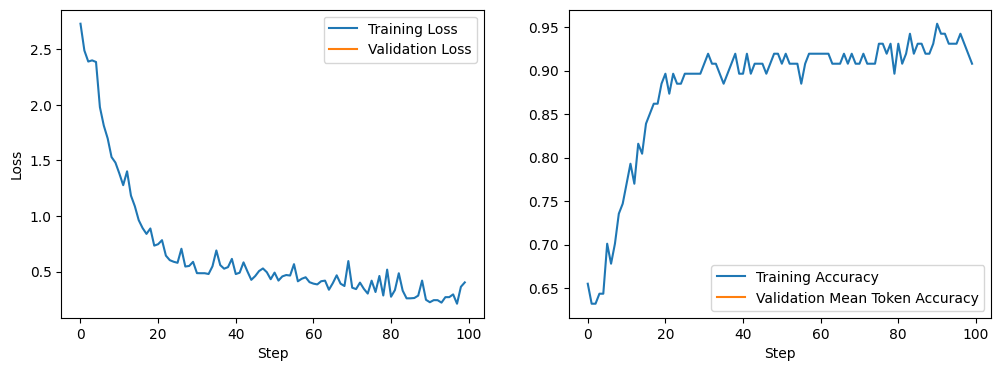

In [89]:
# content = client.files.content(job_response.result_files[0])
file_id = "file-XHXiH7MSUdItVNo00qj1tIE2"
metrics_df = pd.read_csv(fu.get_ft_results(file_id))
display(metrics_df.head())


# plot the training loss and validation loss as lines in one plot
# print two plots next to eachtother
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
ax[0].plot(df["train_loss"], label="Training Loss")
ax[0].plot(df["valid_loss"], label="Validation Loss")
ax[0].set_xlabel("Step")
ax[0].set_ylabel("Loss")
ax[0].legend()

ax[1].plot(df["train_accuracy"], label="Training Accuracy")
ax[1].plot(df["valid_mean_token_accuracy"], label="Validation Mean Token Accuracy")
ax[1].set_xlabel("Step")
ax[1].legend()

plt.show()

In [ ]:
# List the checkpoints of the model
# and save output in a json
# with the following curl command
# curl https://api.openai.com/v1/fine_tuning/jobs/{fine_tune_job_id}/checkpoints \ -H "Authorization: Bearer {API_key}" -o checkpoint_output.json

- Was bringt es, Chckpoints zu saven?
- Code in eine funktion.

Cancel or track a fine-tune job or delete a model

In [ ]:
# List 10 fine-tuning jobs
client.fine_tuning.jobs.list(limit=10)

# Retrieve the state of a fine-tune
client.fine_tuning.jobs.retrieve("ftjob-abc123")

# Cancel a job
client.fine_tuning.jobs.cancel("ftjob-abc123")

# List up to 10 events from a fine-tuning job
client.fine_tuning.jobs.list_events(fine_tuning_job_id="ftjob-abc123", limit=10)

# Delete a fine-tuned model (must be an owner of the org the model was created in)
client.models.delete("ft:gpt-3.5-turbo:acemeco:suffix:abc123")

- vote id in training und test data und in prompt

In [41]:
# Convert list ouput back to a dataframe

response_ls = ['ECR%:0.839, EPP%:0.898, EFD/IDG%:0.562, Greens/EFA%:0.932, NI%:0.294, REG%:0.892, S&D%:0.89, The Left%:0.731, General Majority:1, Left Majority:0, Right Majority:0, Consensus:0', 'ECR%:0.563, EPP%:0.784, EFD/IDG%:0.269, Greens/EFA%:0.815, NI%:0.167, REG%:0.759, S&D%:0.803, The Left%:0.688, General Majority:0, Left Majority:0, Right Majority:0, Consensus:0', 'ECR%:0.59, EPP%:0.802, EFD/IDG%:0.188, Greens/EFA%:0.875, NI%:0.154, REG%:0.844, S&D%:0.815, The Left%:0.62, General Majority:1, Left Majority:0, Right Majority:0, Consensus:0', 'ECR%:0.636, EPP%:0.787, EFD/IDG%:0.295, Greens/EFA%:0.852, NI%:0.273, REG%:0.795, S&D%:0.813, The Left%:0.568, General Majority:1, Left Majority:0, Right Majority:0, Consensus:0', 'ECR%:0.846, EPP%:0.898, EFD/IDG%:0.423, Greens/EFA%:0.892, NI%:0.308, REG%:0.844, S&D%:0.885, The Left%:0.731, General Majority:1, Left Majority:0, Right Majority:0, Consensus:0', 'ECR%:0.828, EPP%:0.898, EFD/IDG%:0.303, Greens/EFA%:0.08, NI%:0.156, REG%:0.83, S&D%:0.772, The Left%:0.06, General Majority:0, Left Maj875, NI%:0.154, REG%:0.844, S&D%:0.815, The Left%:0.62, General Majority:1, Left Majority:0, Right Majority:0, Consensus:0', 'ECR%:0.636, EPP%:0.787, EFD/IDG%:0.295, Greens/EFA%:0.852, NI%:0.273, REG%:0.795, S&D%:0.813, The Left%:0.568, General Majority:1, Left Majority:0, Right Majority:0, Consensus:0', 'ECR%:0.846, EPP%:0.898, EFD/IDG%:0.423, Greens/EFA%:0.892, NI%:0.308, REG%:0.844, S&D%:0.885, The Left%:0.731, General Majority:1, Left Majority:0, Right Majority:0, Consensus:0', 'ECR%:0.828, EPP%:0.898, EFD/IDG%:0.303, Greens/EFA%:0.08, NI%:0.156, REG%:0.83, S&D%:0.772, The Left%:0.06, General Majority:0, Left MajS&D%:0.813, The Left%:0.568, General Majority:1, Left Majority:0, Right Majority:0, Consensus:0', 'ECR%:0.846, EPP%:0.898, EFD/IDG%:0.423, Greens/EFA%:0.892, NI%:0.308, REG%:0.844, S&D%:0.885, The Left%:0.731, General Majority:1, Left Majority:0, Right Majority:0, Consensus:0', 'ECR%:0.828, EPP%:0.898, EFD/IDG%:0.303, Greens/EFA%:0.08, NI%:0.156, REG%:0.83, S&D%:0.772, The Left%:0.06, General Majority:0, Left Majority:0, Right Majority:0, Consensus:0', 'ECR%:0.824, EPP%:0.853, EFD/IDG%:0.333, Greens/EFA%:0.91, NI%:0.154, REG%:0.896, S&D%:0.853, The Left%:0.08, General Majority:1, Left Majority:1, Right Majority:0, Co, General Majority:1, Left Majority:0, Right Majority:0, Consensus:0', 'ECR%:0.828, EPP%:0.898, EFD/IDG%:0.303, Greens/EFA%:0.08, NI%:0.156, REG%:0.83, S&D%:0.772, The Left%:0.06, General Majority:0, Left Majority:0, Right Majority:0, Consensus:0', 'ECR%:0.824, EPP%:0.853, EFD/IDG%:0.333, Greens/EFA%:0.91, NI%:0.154, REG%:0.896, S&D%:0.853, The Left%:0.08, General Majority:1, Left Majority:1, Right Majority:0, Coority:0, Right Majority:0, Consensus:0', 'ECR%:0.824, EPP%:0.853, EFD/IDG%:0.333, Greens/EFA%:0.91, NI%:0.154, REG%:0.896, S&D%:0.853, The Left%:0.08, General Majority:1, Left Majority:1, Right Majority:0, Consensus:0', 'ECR%:0.714, EPP%:0.728, EFD/IDG%:0.375, Greens/EFA%:0.885, NI%:0.219, REG%:0.846, S&D%:0.786, The Left%:0.609, General Majority:0, Left Majority:0, Right Majority:0, Consensus:0', 'ECR%:0.867, EPnsensus:0', 'ECR%:0.714, EPP%:0.728, EFD/IDG%:0.375, Greens/EFA%:0.885, NI%:0.219, REG%:0.846, S&D%:0.786, The Left%:0.609, General Majority:0, Left Majority:0, Right Majority:0, Consensus:0', 'ECR%:0.867, EPP%:0.901, EFD/IDG%:0.438, Greens/EFA%:0.81, NI%:0.154, REG%:0.839, S&D%:0.854, The Left%:0.731, General Majority:0, Left Majority:0, Right Majority:0, Consensus:0', 'ECR%:0.898, EPP%:0.935, EFD/IDG%:0.625, Greens/EFA%:0.957, NI%:0.542, REG%:0.865, S&D%:0.901, The Left%:0.766, General Majority:1, Left Majority:0, Right Majority:0, Consensus:0']
# Function to convert each string into a dictionary
def parse_string_ls_to_dict(s):
    result = {}
    # delete all ' from string
    s = s.replace("'", "")
    # split key value paris from each other
    for item in s.split(', '):
        # split party names from values
        parts = item.split(':')
        if len(parts) == 2:
            # turn key value pairs into dictionary
            key, value = parts
            result[key] = value
        else:
            print(f"Skipping incorrectly formatted item: {item}")
    return result

# Convert list of strings to list of dictionaries
response_dicts = [parse_string_ls_to_dict(item) for item in response_ls]

# Convert list of dictionaries to DataFrame
response_df = pd.DataFrame(response_dicts)

# Convert numeric columns to float
response_df = df.apply(pd.to_numeric, errors='ignore')

display(response_df)

# Calculate accuracy
acc = fu.get_accuracy_df(response_df, 0.05)

Skipping malformed item: Left Maj875
Skipping malformed item: Co
20


C:\Users\Cäcilia\AppData\Local\Temp\ipykernel_3048\2671900495.py:30: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df = df.apply(pd.to_numeric, errors='ignore')


,ECR%,EPP%,EFD/IDG%,Greens/EFA%,NI%,REG%,S&D%,The Left%,General Majority,Left Majority,Right Majority,Consensus,Left MajS&D%,Coority,EPnsensus
0,0.839,0.898,0.562,0.932,0.294,0.892,0.890,0.731,1.0,0.0,0.0,0.0,NaN,NaN,NaN
1,0.563,0.784,0.269,0.815,0.167,0.759,0.803,0.688,0.0,0.0,0.0,0.0,NaN,NaN,NaN
2,0.590,0.802,0.188,0.875,0.154,0.844,0.815,0.620,1.0,0.0,0.0,0.0,NaN,NaN,NaN
3,0.636,0.787,0.295,0.852,0.273,0.795,0.813,0.568,1.0,0.0,0.0,0.0,NaN,NaN,NaN
4,0.846,0.898,0.423,0.892,0.308,0.844,0.885,0.731,1.0,0.0,0.0,0.0,NaN,NaN,NaN
5,0.828,0.898,0.303,0.080,0.154,0.844,0.815,0.620,1.0,0.0,0.0,0.0,NaN,NaN,NaN
6,0.636,0.787,0.295,0.852,0.273,0.795,0.813,0.568,1.0,0.0,0.0,0.0,NaN,NaN,NaN
7,0.846,0.898,0.423,0.892,0.308,0.844,0.885,0.731,1.0,0.0,0.0,0.0,NaN,NaN,NaN
8,0.828,0.898,0.303,0.080,0.156,0.830,0.772,0.568,1.0,0.0,0.0,0.0,0.813,NaN,NaN
9,0.846,0.898,0.423,0.892,0.308,0.844,0.885,0.731,1.0,0.0,0.0,0.0,NaN,NaN,NaN


Using fine-tuned model via Playground or via code

In [ ]:
# make a request to the new model
completion = client.chat.completions.create(
  model="ft:gpt-3.5-turbo:my-org:custom_suffix:id",
  messages=[
    {"role": "system", "content": "You are a helpful assistant."},
    {"role": "user", "content": "Hello!"}
  ]
)
print(completion.choices[0].message)